# Proyecto Final A

En este proyecto trabajaremos con un modelo de [recomendación de arte](https://arxiv.org/abs/1706.07515) que vimos en la clase número 3. El modelo de recomendación de arte es un modelo basado en contenido, donde se utilizan redes neuronales convolucionales para el cálculo de similaridades de ítems. Luego, dependiendo de los productos que el usuario ha consumido, se recomiendan los ítems más similares.

In [2]:
import numpy as np
import json
import requests
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from PIL import Image
from io import BytesIO
import pickle

## Load pre-trained CNN features: ResNet50 and VGG19

En esta sección se trabajará con modelos pre-entrenados de las arquitecturas ResNet50 y VGG19

Para los curiosos se recomienda revisar los siguientes links:

- Artículo: (Understand Deep Residual Networks)[https://blog.waya.ai/deep-residual-learning-9610bb62c355]
- (Keras applications)[https://keras.io/applications/]

Para efectos de este trabajo los vectores característicos y fueron entrenados y guardados en archivos numpy. A continuación son cargads en memoria.

In [4]:
resnet50_featmat = np.load('./assets/resnet50_feature_matrix.npy')
vgg19_featmat = np.load('./assets/vgg19_feature_matrix.npy')

**Pregunta** ¿Por qué el uso de una red convolucional es una buena elección para este tipo de problema?

**Respuesta**

## Load additional json files

En esta sección se cargan archivos auxiliares que luego serán útiles para el cálculo de las recomendaciones.

In [10]:
print('Loading index2artworkId.json')
with open('./assets/index2artworkId.json') as f:
    index2id = json.load(f)
    id2index = {_id:i for i,_id in enumerate(index2id)}
    
print('Loading artworkImageUrlsCache.json')
with open('./assets/artworkImageUrlsCache.json') as f:
    image_urls_cache = json.load(f)
    
print('Loading past_transactions.pickle')
with open('./assets/past_transactions.pickle', 'rb') as f:
    past_transactions = pickle.load(f)
    
print('Loading ground_truth.pickle')
with open('./assets/ground_truth.pickle', 'rb') as f:
    ground_truth = pickle.load(f)
    
len(index2id), resnet50_featmat.shape, vgg19_featmat.shape

Loading index2artworkId.json
Loading artworkImageUrlsCache.json
Loading past_transactions.pickle
Loading ground_truth.pickle


(300, (300, 2048), (300, 4096))

## Concatenate  ResNet50 + VGG19, apply z-score normalization and finally PCA(100)

Una vez calculado (o cargado) los vectores característicos de cada imagen, se deben preprocesar para generar un único vector por cada instancia. Para lograr este objetivo se concatenan los vectores de las redes ResNet50 y VGG19, luego son normalizados restando la media del vector a cada dimensión y luego dividir por su desviación estándar.

$x_i = \frac{x_i - \bar{x}}{\sigma}$

Finalmente los vectores son reducidos a una dimensión de 100 mediante la técnica PCA.

In [12]:
def normalize_zscore_inplace(featmat):
    means = featmat.mean(0)
    stds = featmat.std(0)
    for i in range(stds.shape[0]):
        if stds[i] == 0:
            stds[i] = 1
    featmat -= means
    featmat /= stds

In [13]:
n_artworks = len(index2id)
resnet50_dim = resnet50_featmat.shape[1]
vgg19_dim = vgg19_featmat.shape[1]

In [22]:
resnet_vgg_hybrid_featmat = np.empty(shape=(n_artworks, resnet50_dim + vgg19_dim))
for i in range(n_artworks):
    resnet_vgg_hybrid_featmat[i][:resnet50_dim] = resnet50_featmat[i]
    resnet_vgg_hybrid_featmat[i][resnet50_dim:] = vgg19_featmat[i]
normalize_zscore_inplace(resnet_vgg_hybrid_featmat)

In [23]:
# Project into a 100 PCA feature space
pca100_resnet_vgg_hybrid_featmat = PCA(n_components=100).fit_transform(resnet_vgg_hybrid_featmat)

**Pregunta** Comente por qué se utiliza PCA para reducir la dimensión de cada vector característico. ¿Qué sucede con la pérdida de información en la reducción de dimensión?

**Respuesta**

## Similar image retrieval

En esta sección utilizaremos los vectores cargados para hacer un sistema de recuperación o búsqueda de información, para diferentes métricas de distancia.

In [29]:
# Download images by url

image_cache = dict()
def get_image(_id):
    _id = str(_id)
    try:
        return image_cache[_id]
    except KeyError:
        url = image_urls_cache[_id]['medium']
        try:
            r = requests.get(url, timeout=3)
        except requests.exceptions.timeout:
            print('timeout detected for url = ', url)
            return None
        if r.status_code == 200:
            img = Image.open(BytesIO(r.content))
            image_cache[_id] = img
            return img
        else:
            return None

In [30]:
# Find similar images by query id

def find_similar_images(embedding, query_id=None, metrics=('euclidean',), topk=5):
    assert len(metrics) > 0
    assert topk <= 20 # to avoid requesting too many images
    n = embedding.shape[0]
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]
        
    # --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(get_image(query_id))
    plt.show()

    # --- show retrieved images for each metric
    for metric in metrics:
        print('-------- retrieved with metric = %s -----' % metric)
        distances = pairwise_distances(embedding[query_i].reshape(1,-1), embedding, metric=metric)
        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        
        fig = plt.figure(1, (20,15))        
        nrows = math.ceil(topk/4)
        ncols = min(topk, 4)
        for i, (_,index) in enumerate(heap):
            ax = plt.subplot(nrows, ncols, i+1)
            _id = index2id[index]
            img = get_image(_id)
            if img is None:
                ax.set_title('%d) id = %d not found' % (i, _id))
            else:
                ax.set_title('%d) id = %d' % (i, _id))
                ax.imshow(img, interpolation="nearest")
        plt.show()

#### Usando ResNet50

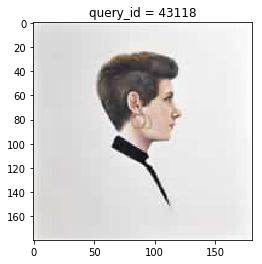

-------- retrieved with metric = cosine -----


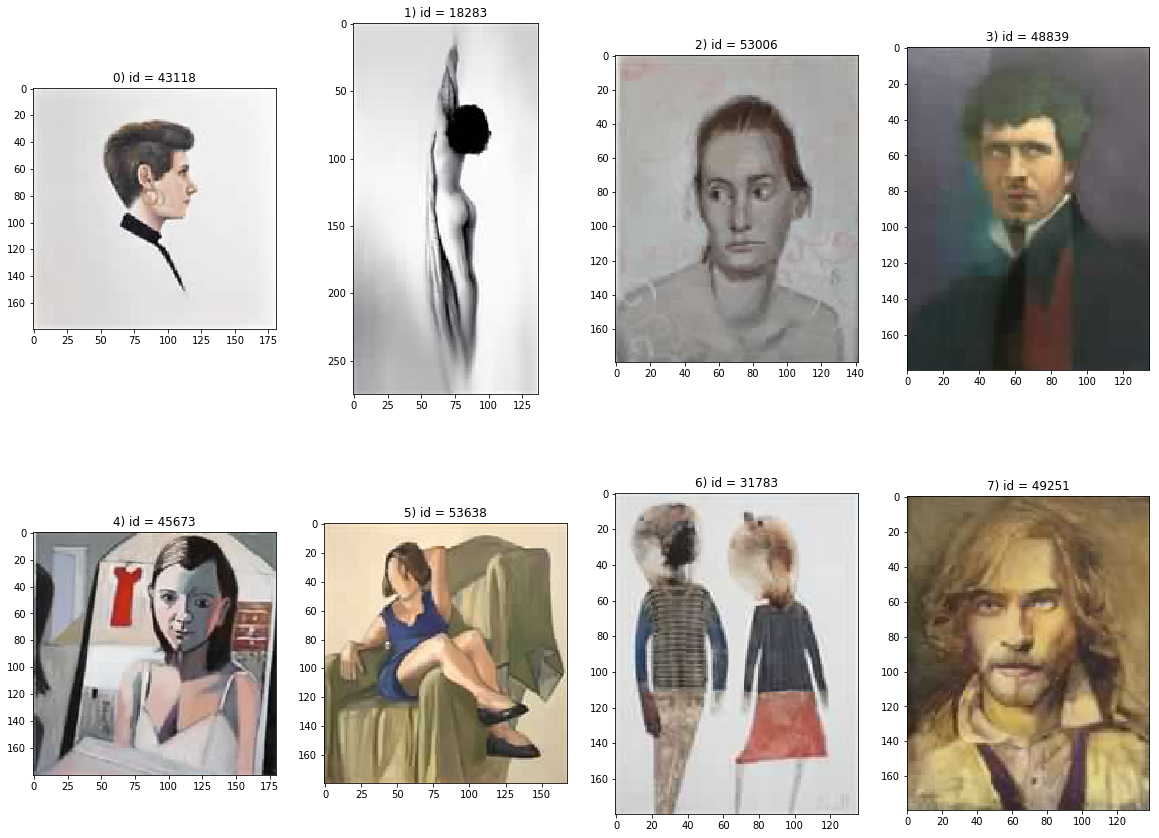

In [31]:
# Retrieve images using ResNet50 and cosine similarity
find_similar_images(resnet50_featmat, metrics=('cosine',), query_id=43118, topk=8)

#### Usando VGG19

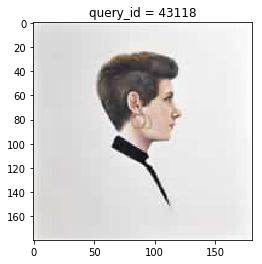

-------- retrieved with metric = cosine -----


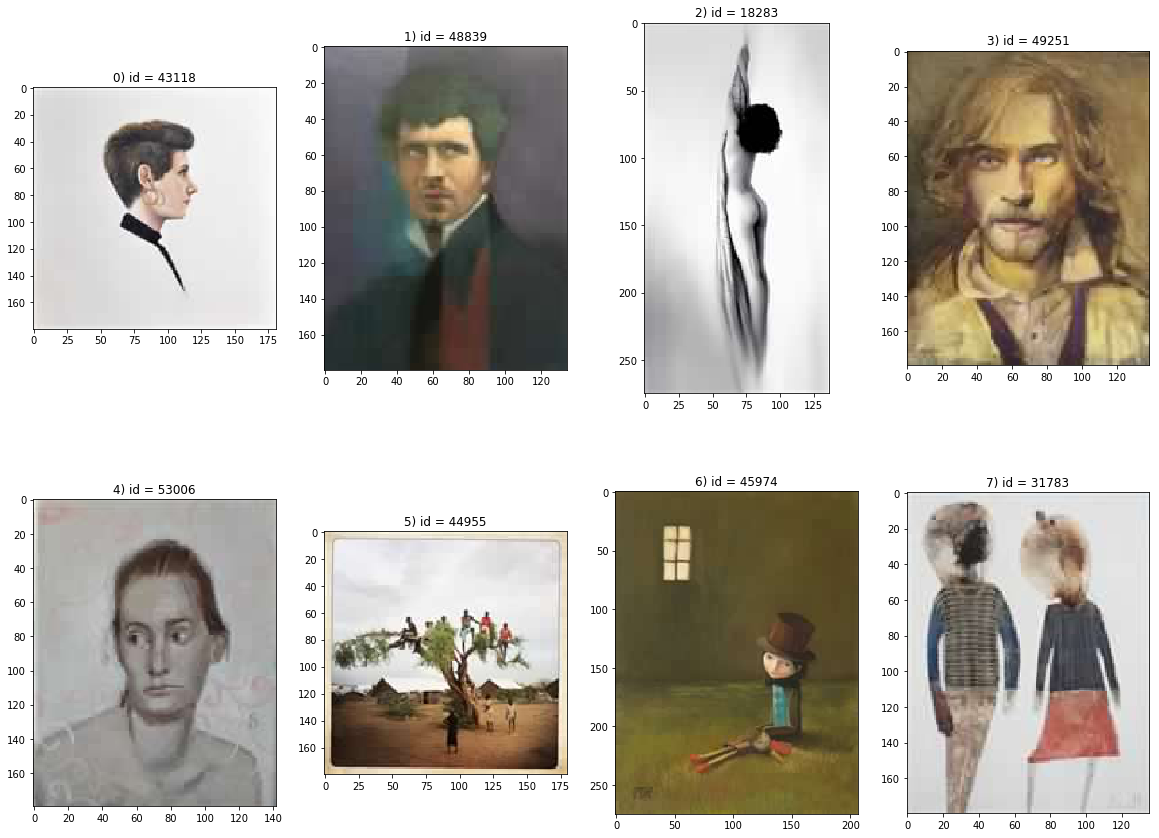

In [32]:
# Retrieve images using VGG19 and cosine similarity
find_similar_images(vgg19_featmat, metrics=('cosine',), query_id=43118, topk=8)

#### 4.3) using PCA(100) over ResNet50+VGG19 hybrid

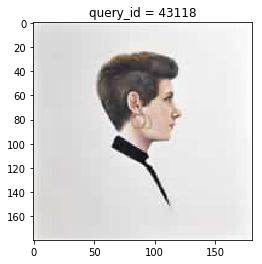

-------- retrieved with metric = cosine -----


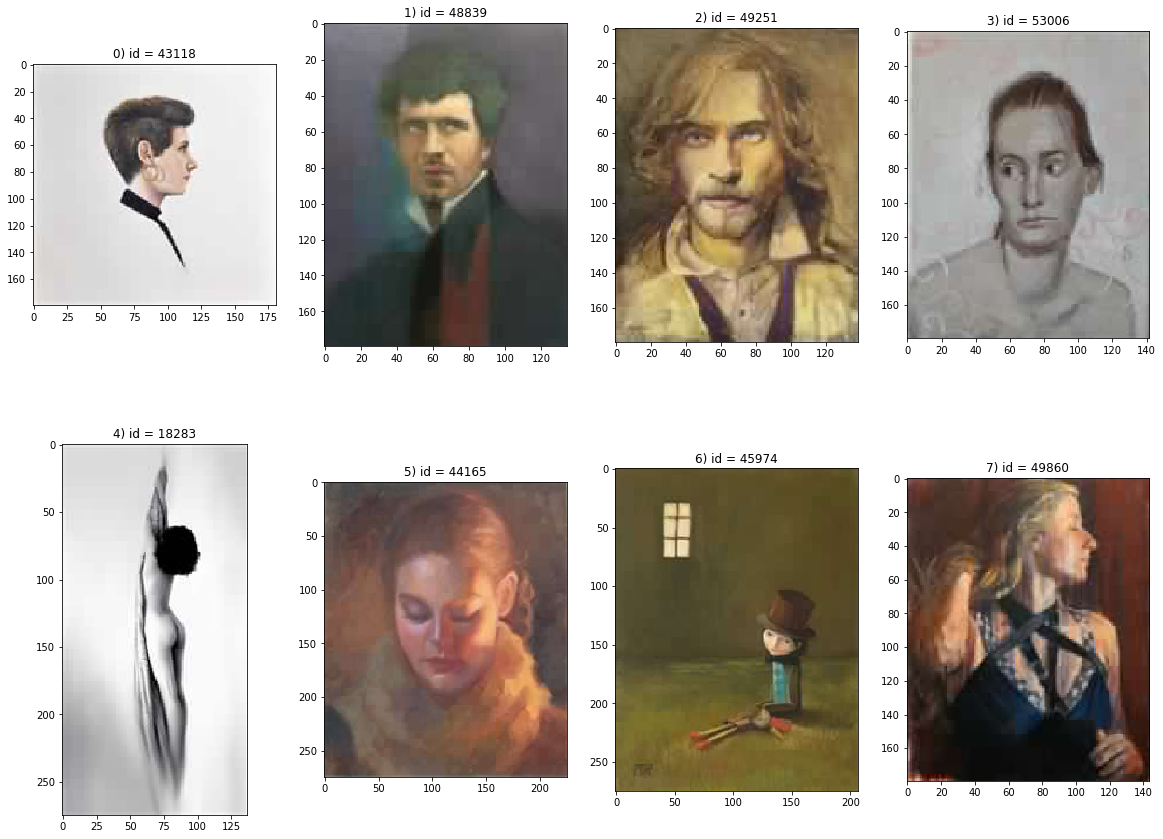

-------- retrieved with metric = euclidean -----


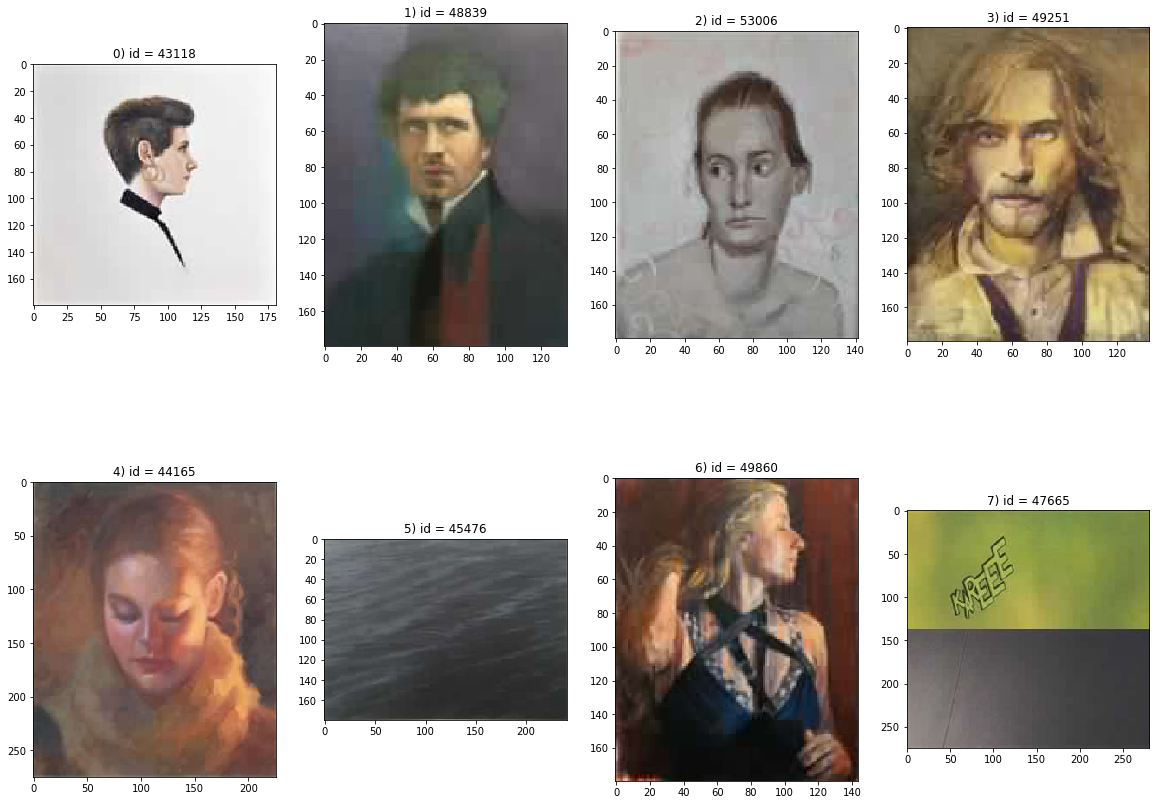

In [33]:
# Retrieve images using PCA features, cosine and euclidean similarity
find_similar_images(pca100_resnet_vgg_hybrid_featmat, metrics=('cosine','euclidean'), query_id=43118, topk=8)

**Pregunta** Comente sobre los resultados al realizar consultas utilizando diferentes métricas de distancia y vectores característicos. ¿Son similares? ¿Cuál crees que es la combinación más apropiada y por qué? Si necesitas hacer otras consultas puedes agregar más celdas.

**Respuesta**